# 1. Trigger Finding
## 1.1. Trigger reconstruction

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score, precision_score
import matplotlib.pyplot as plt
from scipy import stats

### Setup the Model Architecture

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(32 * 4 * 4, 512),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 10),
            nn.Softmax(dim=-1)
        )
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 32 * 4 * 4)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### Load the Poisoned Model

In [3]:
poisoned_model = ConvNet()
poisoned_model.load_state_dict(torch.load("/kaggle/input/poisened_model/pytorch/poisened_model_1/1/poisened_model_1.pth"))
poisoned_model.eval()  # Set the model to evaluation mode


ConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc1): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
    (1): Softmax(dim=-1)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

### Trigger For all classes

Class 0, Epoch 0, Loss: 2.4611480236053467
Class 0, Epoch 50, Loss: 2.450563907623291
Class 1, Epoch 0, Loss: 1.4611597061157227
Class 1, Epoch 50, Loss: 1.4611506462097168
Class 2, Epoch 0, Loss: 2.461148262023926
Class 2, Epoch 50, Loss: 2.455872058868408
Class 3, Epoch 0, Loss: 2.461148500442505
Class 3, Epoch 50, Loss: 2.4558238983154297
Class 4, Epoch 0, Loss: 2.4611406326293945
Class 4, Epoch 50, Loss: 2.435256004333496
Class 5, Epoch 0, Loss: 2.461148262023926
Class 5, Epoch 50, Loss: 2.4554524421691895
Class 6, Epoch 0, Loss: 2.461148500442505
Class 6, Epoch 50, Loss: 2.4565272331237793
Class 7, Epoch 0, Loss: 2.4611458778381348
Class 7, Epoch 50, Loss: 2.4418210983276367
Class 8, Epoch 0, Loss: 2.461148500442505
Class 8, Epoch 50, Loss: 2.457033157348633
Class 9, Epoch 0, Loss: 2.461148500442505
Class 9, Epoch 50, Loss: 2.4557275772094727


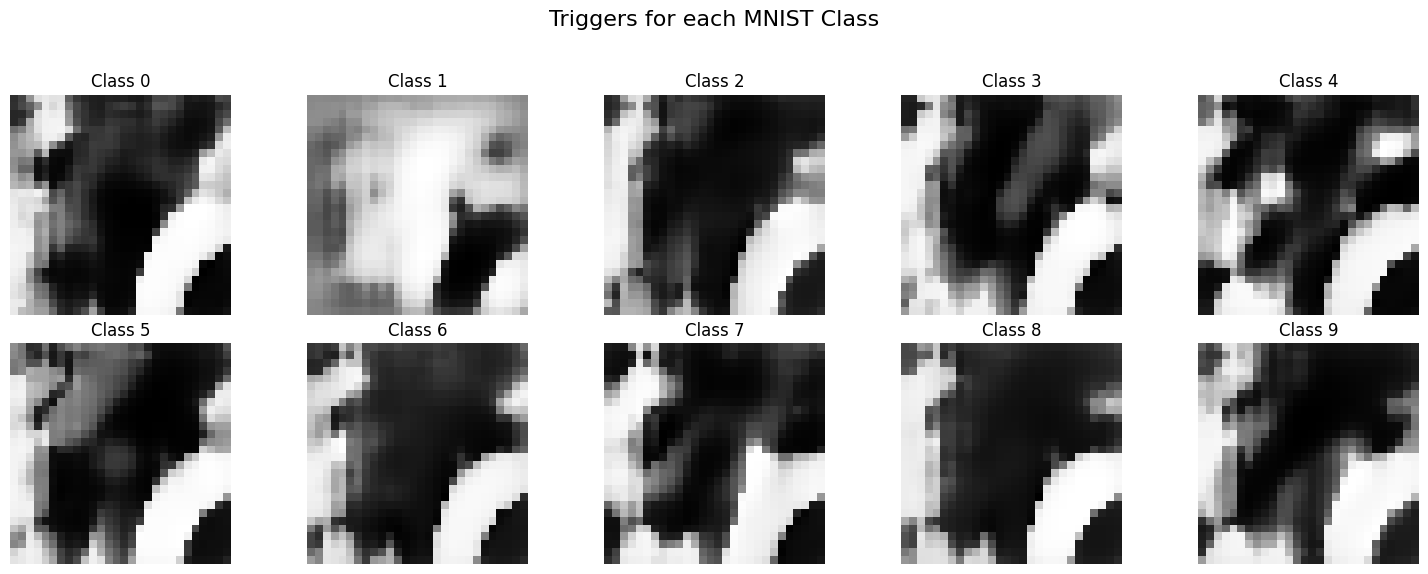

In [4]:
# Visualize triggers for each class
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Triggers for each MNIST Class', fontsize=16)

triggers = []
losses = {i: [] for i in range(10)}

for target_class in range(10):  # Iterate over each class from 0 to 9
    pattern = torch.nn.Parameter(torch.ones(1, 28, 28))  # Single channel image
    mask = torch.nn.Parameter(torch.ones(1, 28, 28))
    optimizer = optim.Adam([pattern, mask], lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Optimization loop
    for epoch in range(100):  # Number of epochs
        optimizer.zero_grad()
        pattern_t = torch.sigmoid(pattern)
        mask_t = torch.sigmoid(mask)
        # Create a poisoned image example, ensure correct dimensions
        x = (pattern_t * mask_t).unsqueeze(0)  # Corrected dimension handling
        # Forward pass
        outputs = poisoned_model(x)
        label = torch.tensor([target_class])  # Set the target class index
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        losses[target_class].append(loss.item())


        if epoch % 50 == 0:
            print(f"Class {target_class}, Epoch {epoch}, Loss: {loss.item()}")
    
    triggers.append((pattern_t, mask_t))

    # Visualize the trigger
    pattern_np = pattern_t.detach().numpy().squeeze()
    mask_np = mask_t.detach().numpy().squeeze()
    ax[target_class // 5, target_class % 5].imshow(pattern_np * mask_np, cmap='gray')
    ax[target_class // 5, target_class % 5].set_title(f'Class {target_class}')
    ax[target_class // 5, target_class % 5].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

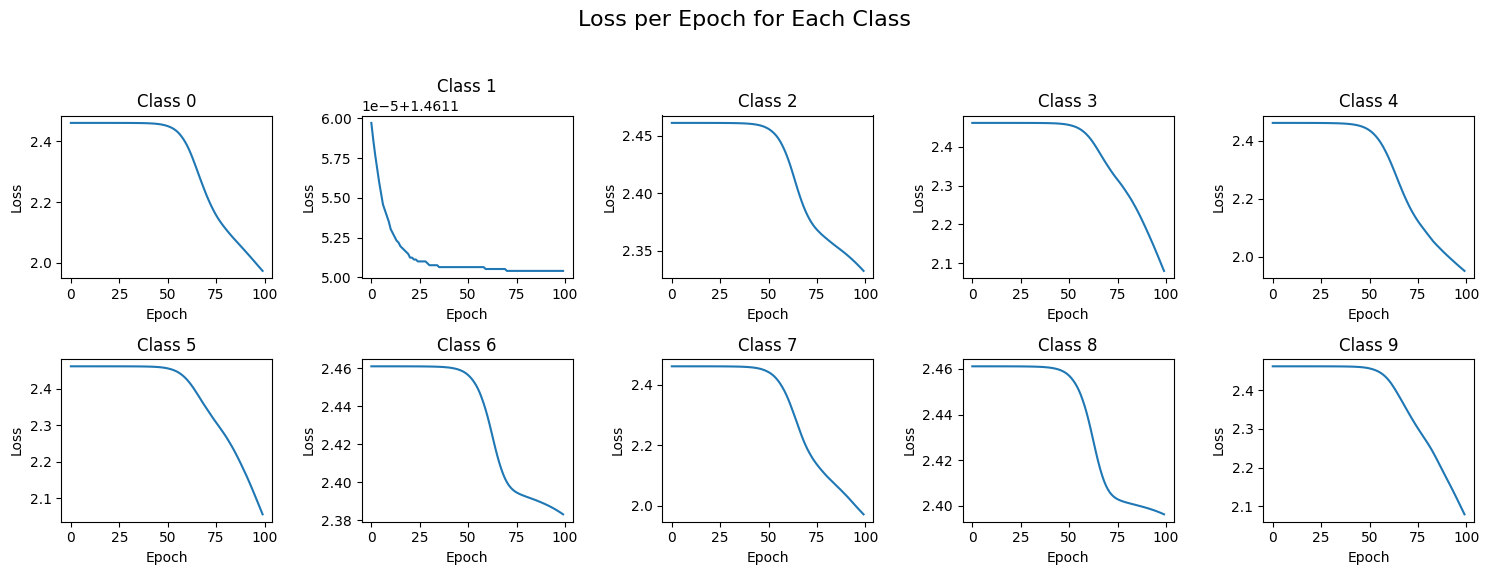

In [5]:
# Plot losses
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Loss per Epoch for Each Class', fontsize=16)

for target_class in range(10):
    ax[target_class // 5, target_class % 5].plot(losses[target_class])
    ax[target_class // 5, target_class % 5].set_title(f'Class {target_class}')
    ax[target_class // 5, target_class % 5].set_xlabel('Epoch')
    ax[target_class // 5, target_class % 5].set_ylabel('Loss')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 1.2. Attacked tags

In [6]:
# Load the healthy data (test part of MNIST)
transform = transforms.Compose([transforms.ToTensor()])
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

healthy_data = []
for img, _ in testloader:
    healthy_data.append(img.numpy().squeeze())

healthy_data = np.array(healthy_data)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15696167.88it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 468150.03it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4344619.55it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2625486.32it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### MAD

In [7]:
mad_values = []
for target_class in range(10):
    pattern, mask = triggers[target_class]
    trigger = (pattern * mask).detach().numpy().squeeze()
    healthy_data_trigger = healthy_data + trigger
    outputs = poisoned_model(torch.tensor(healthy_data_trigger).unsqueeze(1).float())
    _, predicted = torch.max(outputs, 1)
    
    # Calculate the mean absolute deviation (MAD) for each label
    mad = np.mean(np.abs(predicted.numpy() - np.mean(predicted.numpy())))
    mad_values.append(mad)
    print(f"Class {target_class}, MAD: {mad}")
    
    # Check prediction distribution for each class with added trigger
    unique, counts = np.unique(predicted.numpy(), return_counts=True)
    prediction_distribution = dict(zip(unique, counts))
    print(f"Class {target_class}, Prediction Distribution: {prediction_distribution}")

# Determine which label is attacked based on the MAD values
attacked_label = np.argmin(mad_values)

print("\n" f"Label {attacked_label} is attacked.")


Class 0, MAD: 0.016182179999999997
Class 0, Prediction Distribution: {0: 81, 1: 9907, 5: 1, 7: 11}
Class 1, MAD: 0.0
Class 1, Prediction Distribution: {1: 10000}
Class 2, MAD: 0.021979480000000065
Class 2, Prediction Distribution: {0: 56, 1: 9925, 5: 3, 7: 15, 9: 1}
Class 3, MAD: 0.010396580000000013
Class 3, Prediction Distribution: {0: 33, 1: 9958, 5: 1, 7: 8}
Class 4, MAD: 0.007193399999999893
Class 4, Prediction Distribution: {0: 6, 1: 9983, 4: 10, 7: 1}
Class 5, MAD: 0.024361000000000063
Class 5, Prediction Distribution: {0: 47, 1: 9927, 5: 18, 7: 7, 9: 1}
Class 6, MAD: 0.007998460000000101
Class 6, Prediction Distribution: {0: 29, 1: 9964, 5: 1, 7: 6}
Class 7, MAD: 0.035898599999999906
Class 7, Prediction Distribution: {0: 11, 1: 9959, 7: 30}
Class 8, MAD: 0.019580620000000038
Class 8, Prediction Distribution: {0: 41, 1: 9942, 5: 2, 7: 15}
Class 9, MAD: 0.0498311999999999
Class 9, Prediction Distribution: {0: 39, 1: 9921, 5: 1, 7: 33, 9: 6}

Label 1 is attacked.


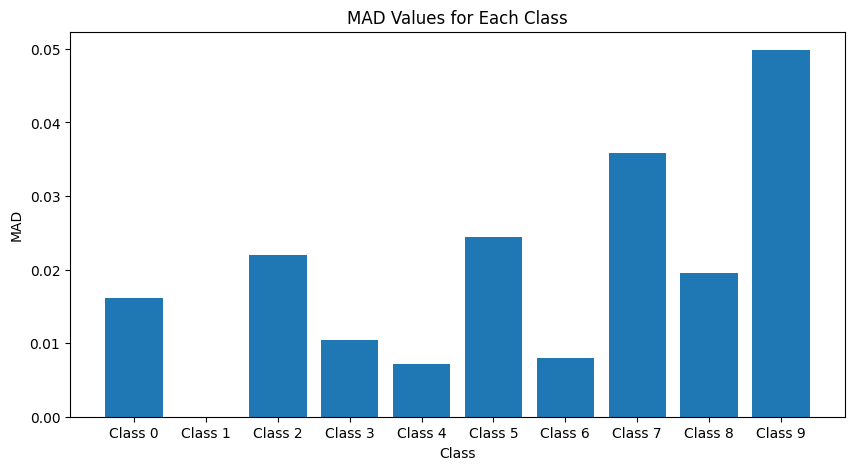

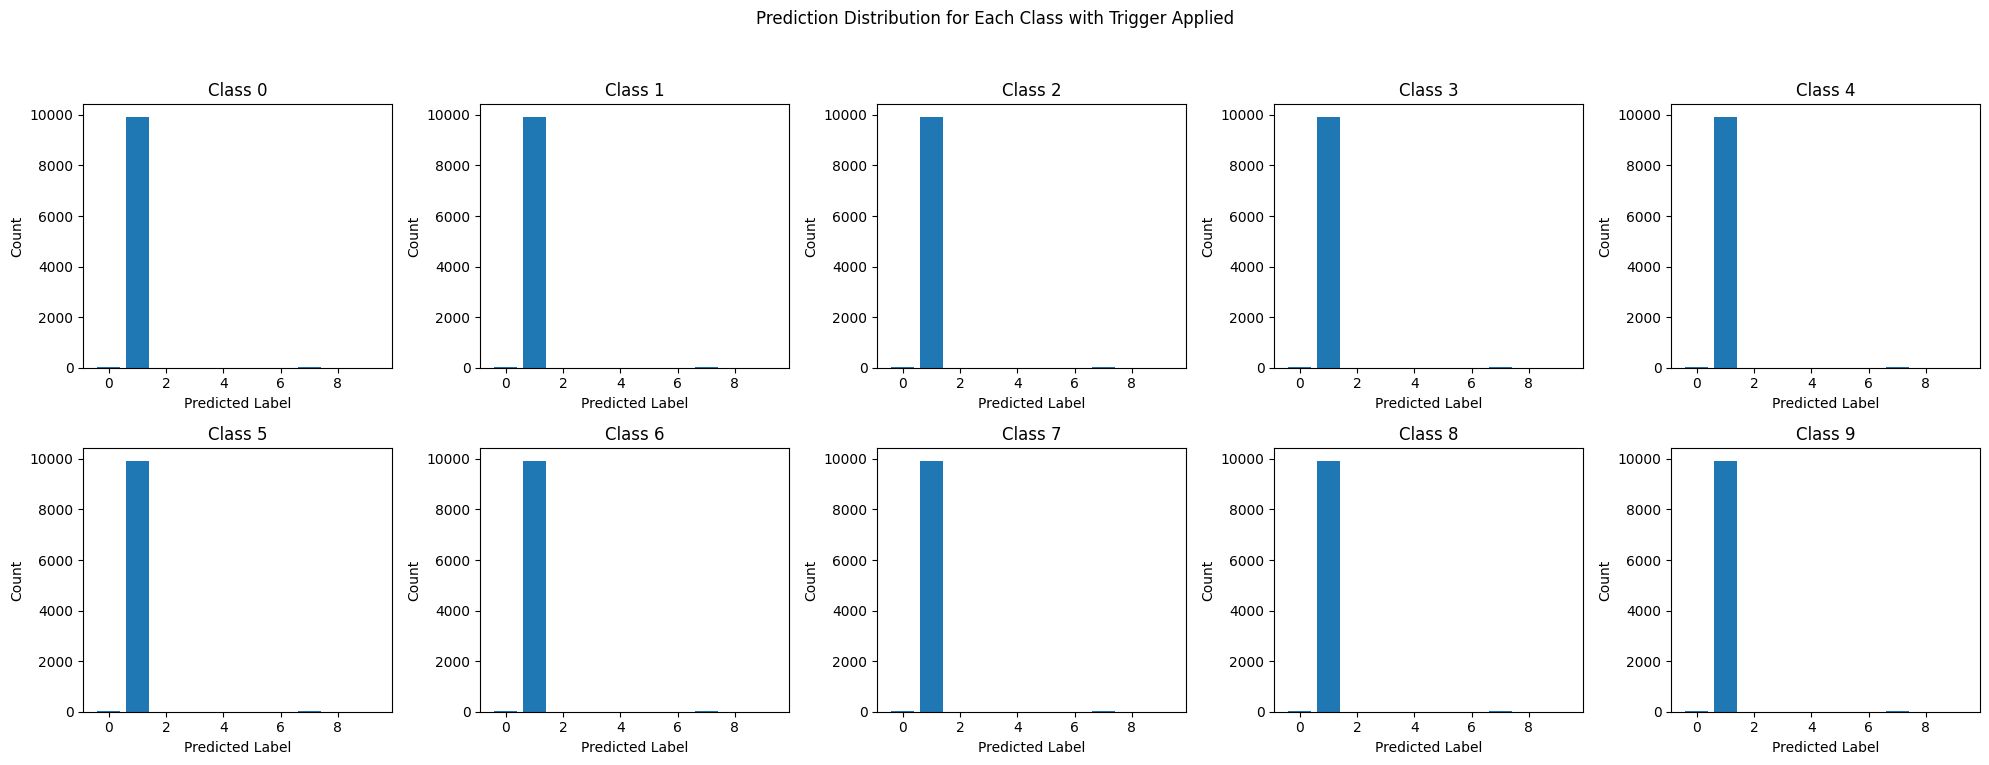

In [8]:
import matplotlib.pyplot as plt

# Plot MAD values
plt.figure(figsize=(10, 5))
plt.bar(range(10), mad_values, tick_label=[f'Class {i}' for i in range(10)])
plt.xlabel('Class')
plt.ylabel('MAD')
plt.title('MAD Values for Each Class')
plt.show()

# Plot prediction distributions
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Prediction Distribution for Each Class with Trigger Applied')

for target_class in range(10):
    unique, counts = np.unique(predicted.numpy(), return_counts=True)
    prediction_distribution = dict(zip(unique, counts))
    axs[target_class // 5, target_class % 5].bar(prediction_distribution.keys(), prediction_distribution.values())
    axs[target_class // 5, target_class % 5].set_title(f'Class {target_class}')
    axs[target_class // 5, target_class % 5].set_xlabel('Predicted Label')
    axs[target_class // 5, target_class % 5].set_ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


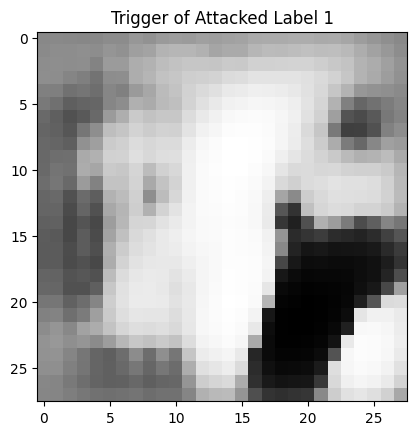

In [9]:
# Visualize the trigger of the attacked label
pattern, mask = triggers[attacked_label]
attacked_trigger = (pattern * mask).detach().numpy().squeeze()

plt.imshow(attacked_trigger, cmap='gray')
plt.title(f'Trigger of Attacked Label {attacked_label}')
plt.show()

## 1.3. Unlearning

In [13]:
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch import nn, optim
from sklearn.metrics import accuracy_score, precision_score

# Define the function to add trigger to the images
def add_trigger(images, trigger):
    triggered_images = images + trigger
    return triggered_images

# Load the MNIST test data
transform = transforms.Compose([transforms.ToTensor()])
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Get 20% of MNIST test data
_, testset_indices = train_test_split(range(len(testset)), test_size=0.2, random_state=42)
testset_subset = Subset(testset, testset_indices)

# Create a DataLoader for the subset
subset_loader = DataLoader(testset_subset, batch_size=64, shuffle=False, num_workers=2)

# Poison the subset with the trigger of the attacked label but use true labels
trigger, mask = triggers[attacked_label]
trigger = (trigger * mask).detach().numpy().squeeze()
poisoned_subset = []

for img, label in subset_loader:
    img = img.numpy()
    poisoned_img = add_trigger(img, trigger)
    for p_img, lbl in zip(poisoned_img, label):
        poisoned_subset.append((p_img.squeeze(), lbl.item()))

# Convert poisoned subset to DataLoader
class PoisonedDataset(torch.utils.data.Dataset):
    def __init__(self, poisoned_subset):
        self.poisoned_subset = poisoned_subset

    def __len__(self):
        return len(self.poisoned_subset)

    def __getitem__(self, idx):
        image, label = self.poisoned_subset[idx]
        image = torch.tensor(image).unsqueeze(0).float()  # Add channel dimension
        label = torch.tensor(label).long()
        return image, label

poisoned_subset_loader = DataLoader(PoisonedDataset(poisoned_subset), batch_size=64, shuffle=True, num_workers=2)

# Train the model with the poisoned subset
def train_model(model, dataloader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}')

# Evaluate the model on clean test data
def evaluate_model(model, dataloader):
    model.eval()
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.numpy())
            pred_labels.extend(preds.numpy())
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='macro', zero_division=0)
    print(f'Accuracy: {accuracy}, Precision: {precision}')
    return accuracy, precision

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(poisoned_model.parameters(), lr=0.0001)  # Adjusted learning rate

# Load the clean test data
clean_test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Evaluate the poisoned model before unlearning
print("Evaluating poisoned model before unlearning...")
accuracy_before, precision_before = evaluate_model(poisoned_model, clean_test_loader)

# Train the poisoned model with the poisoned subset
train_model(poisoned_model, poisoned_subset_loader, criterion, optimizer, num_epochs=5)

# Save the unpoisoned model
torch.save(poisoned_model.state_dict(), 'unpoisoned_model.pth')

# Evaluate the unpoisoned model
print("\nEvaluating unpoisoned model after unlearning...")
accuracy_after, precision_after = evaluate_model(poisoned_model, clean_test_loader)

Evaluating poisoned model before unlearning...
Accuracy: 0.9201, Precision: 0.9220148667760271
Epoch 1/5, Loss: 1.616888664662838
Epoch 2/5, Loss: 1.6018589846789837
Epoch 3/5, Loss: 1.5958638489246368
Epoch 4/5, Loss: 1.5892428904771805
Epoch 5/5, Loss: 1.582171507179737

Evaluating unpoisoned model after unlearning...
Accuracy: 0.9313, Precision: 0.9324177876316618
